Introduction

The goal of this analysis is to demonstrate the usage of topic modeling using Python on the New Yorker Caption Contest database. By performing topic modeling on multiple contests, we can see which topics are common across them and perhaps in the future use this information to infer on what makes a caption funny. To perform topic modeling, I will use an algorithm called Latent Dirichlet Allocation (LDA) to grab topic vectors and visualize common topics. The data is collected from https://nextml.github.io/caption-contest-data/ and is stored on a SQL database. I will primarily be using data from the last 5 contests for time and memory purposes. 

The first step of this analysis is to pull down our data from the SQL database in which the code block below does so. I am requesting a connection to the SQL database by using a Python package called mysql.connector which allows Python progams to have access to SQL databases. The database I am pulling down information from is called new york cartoon.

In [1]:
# connecting to SQL database
import mysql.connector
from mysql.connector import Error
import pandas as pd
pd.set_option('display.max_colwidth', None)

try:
    connection = mysql.connector.connect(host='dbnewyorkcartoon.cgyqzvdc98df.us-east-2.rds.amazonaws.com',
                                         database='new_york_cartoon',
                                         user='dbuser',
                                         password='Sql123456')
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You succeed to connect to database: ", record)

except Error as e:
    print("Error while connecting to MySQL", e)

Connected to MySQL Server version  8.0.33
You succeed to connect to database:  ('new_york_cartoon',)


In order to understand how we can get our data from SQL, we have to input what contest numbers we want our captions from. In this case, we want data from contests 853, 852, 851, 850, 849. We can do this using SQL's search function which allows to get data from the last 5 contests and show it in a Pandas dataframe for ease of usage.

In [2]:
# pulling down data from SQL database via search
sql_select_Query = "select caption,ranking from result where contest_num in (853, 852, 851, 850, 849);"  # you can change query in this line for selecting your target data
cursor.execute(sql_select_Query)

# show attributes names of target data
num_attr = len(cursor.description)
attr_names = [i[0] for i in cursor.description]
print(attr_names)

# get all records
records = cursor.fetchall()
print("Total number of rows in table: ", cursor.rowcount)
df = pd.DataFrame(records, columns=attr_names)
df

['caption', 'ranking']
Total number of rows in table:  26897


,caption,ranking
0,How do I look? Yea or neigh?,0
1,It's for an interview. I'm looking for a stable job.,1
2,I'd like my wife's opinion. She's over in the bridle section.,2
3,No one knows you aren't wearing pants on Zoom.,3
4,The invite just says coat and tails.,4
...,...,...
26892,It can’t be authentic - Swi,4675
26893,I try all cheese. I eat what I can.,4676
26894,A cheese board for the whole ship? Where’s the iceberg lettuce?,4677
26895,Swiss has no place on our cheese board! Let's hope it drifts toward a cruise ship.,4678


In [3]:
# libraries for topic modeling
import pandas as pd
import numpy as np
import gensim
from gensim import models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import re
from collections import defaultdict 
from numpy import dot
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

I am using the gensim package for preprocessing and topic modeling which is an open source Python library representing documents as semantic vectors, as efficiently and painlessly as possible. It is designed to process raw, unstructured digital texts (“plain text”) using unsupervised machine learning algorithms. This is the fastest library for natural language processing and it is easy to use and understand.

The second step of this analysis is to first get rid of any distracting information or columns that are not useful to us in text extraction. As we can see in our dataframe (df), we have two columns called caption and ranking in which the former contains the text that we want to analyze. The second column, ranking, is not needed in our analysis because its values contain numbers which do not contain any meaningful information. Therefore, I will drop the "ranking" column.

In [4]:
for column_name in df.columns:
    print(column_name)

# remove unneccessary columns, axis = 1 means to remove vertical axis(columns)
df = df.drop(columns=['ranking'], axis=1)

df.head()

caption
ranking


,caption
0,How do I look? Yea or neigh?
1,It's for an interview. I'm looking for a stable job.
2,I'd like my wife's opinion. She's over in the bridle section.
3,No one knows you aren't wearing pants on Zoom.
4,The invite just says coat and tails.


Stopwords are a set of commonly used words in any language in this case, English. Removing stopwords is very important in text processing as it can remove noise from the data and provide greater semantical meaning with those words removed. The most common corpus used for stopwords is NLTK's dictionary, but I have opted to use Spacy's dictionary instead. Spacy's dictionary of stopwords is larger thus potentially removing more noise from the data and having a cleaner look at the most important words. I load stopwords from the Spacy library and choose stopwords in English since our text is in English.

In [5]:
# loading stopwords from Spacy
en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words

Next, we have to perform some preprocessing of our text. Preprocessing of text before any form of analysis is very important because it can remove noise such as unnecessary punctuation which contain no meaning. It also allows us to homogenize all the words through lowercasing them. Having uppercase letters might cause variation in how the text is analyzed which can cause different results in our topics models.
Apparently, the values in the column are classified as objects when they should be strings, so I will convert them to strings before performing preprocessing. Here, I am creating a new column called "caption_processed" because I want to see how the text changes once we have finished our preprocessing for clarity purposes. I am using the re library to substitute all the punctuation in the brackets with a blank space and I am lowercasing all words using the lower function. 

In [6]:
# Remove punctuation lowercasing and creating new column "caption_processed"
df['caption'] = df['caption'].astype(str)
df['caption_processed'] = df['caption'].map(lambda x: re.sub('[,\.\!\?\'"]', '', x).lower())

# Print out the first rows of captions
df.head()

<>:3: DeprecationWarning: invalid escape sequence '\.'
<>:3: DeprecationWarning: invalid escape sequence '\.'
C:\Users\alexc\AppData\Local\Temp\ipykernel_5080\3027182456.py:3: DeprecationWarning: invalid escape sequence '\.'
  df['caption_processed'] = df['caption'].map(lambda x: re.sub('[,\.\!\?\'"]', '', x).lower())


,caption,caption_processed
0,How do I look? Yea or neigh?,how do i look yea or neigh
1,It's for an interview. I'm looking for a stable job.,its for an interview im looking for a stable job
2,I'd like my wife's opinion. She's over in the bridle section.,id like my wifes opinion shes over in the bridle section
3,No one knows you aren't wearing pants on Zoom.,no one knows you arent wearing pants on zoom
4,The invite just says coat and tails.,the invite just says coat and tails


The next step is to lemmatize the text. Lemmatization is a preprocessing method that reduces words to their root form. By lemmatizing words before tokenizing allows for efficient and faster processing afterwards. I am creating a function called "lemmatization" that takes in nouns, adjectives, verbs, and adjectives from Spacy's vocabulary. I am using Spacy's model "en_core_web_sm" which is a small English pipeline trained on written web text that includes vocabulary, syntax and entities. I am using the small model for faster computational purposes. In this function, I am lemmatizing words that are in the text and in "allowed_postags" and then appending them into an empty list "texts_out" which will contain all the new lemmatized words.

In [7]:
# lemmatization function
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable = ["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

lemmatized_texts = lemmatization(df.caption_processed)
print(lemmatized_texts)

['look yea neigh', 'interview m look stable job', 'wife opinion s over bridle section', 'one know wear pant zoom', 'invite just say coat tail', 'm get hitch', 'help find polo shirt', 'black tie tail event', 'part love', 'm look ride back', 'zoom call ’d never even know', 'm go bridle shower', 'sorry mess dressing room', 'like centaur attention', '’m go run well half', 'worry make ass look big', '’m bit clothe horse', 'size hand', 'say so certainly look stud', 'wife ride pretty hard get new suit', 'fine ill stand podium whole time', '’m look centaur attention', 'tie too want stand', 'dressage formal year', 'like vest tie make look ass', 'go dressing room want careful step', 'really make ass look big', 'm really become clothe horse', 'm just sure work shoe', 'party call tail', 'now ’ race', 'also use groom', 'truly clotheshorse', 'm worried tie too distract', 'think forget tail', 'blue tie yea neigh', 'tie make stand too much', 'spouse one wear pant family', 'make look horse', 'now let t

Here, I am creating another two functions called gen_words and remove_stopwords in which the former reduces the text to individual words or tokens and the latter removing stopwords from those tokens. In the first function, I am creating a empty list "final" which the words will be appended to and using the simple_preprocess function from gensim which tokenizes text and passing it through an interative for loop. The second function is simply using the simple_preprocess function again to remove stopwords that are from Spacy's dictionary found in the text. This will create many sublists within a large list which is fine for the lda model.

In [8]:
# tokenizing text
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc = True)
        final.append(new)
    return(final)

# removing stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stopwords] for doc in texts]

data_words = gen_words(lemmatized_texts)
data_words = remove_stopwords(data_words)
print(data_words) # for lda model

[['look', 'yea', 'neigh'], ['interview', 'look', 'stable', 'job'], ['wife', 'opinion', 'bridle', 'section'], ['know', 'wear', 'pant', 'zoom'], ['invite', 'coat', 'tail'], ['hitch'], ['help', 'find', 'polo', 'shirt'], ['black', 'tie', 'tail', 'event'], ['love'], ['look', 'ride'], ['zoom', 'know'], ['bridle', 'shower'], ['sorry', 'mess', 'dressing', 'room'], ['like', 'centaur', 'attention'], ['run', 'half'], ['worry', 'ass', 'look', 'big'], ['bit', 'clothe', 'horse'], ['size', 'hand'], ['certainly', 'look', 'stud'], ['wife', 'ride', 'pretty', 'hard', 'new', 'suit'], ['fine', 'ill', 'stand', 'podium', 'time'], ['look', 'centaur', 'attention'], ['tie', 'want', 'stand'], ['dressage', 'formal', 'year'], ['like', 'vest', 'tie', 'look', 'ass'], ['dressing', 'room', 'want', 'careful', 'step'], ['ass', 'look', 'big'], ['clothe', 'horse'], ['sure', 'work', 'shoe'], ['party', 'tail'], ['race'], ['use', 'groom'], ['truly', 'clotheshorse'], ['worried', 'tie', 'distract'], ['think', 'forget', 'tail']

Before building our LDA model, we have to create a dictionary called id2word which allows to look up individual words and their frequency in the text. This is a useful tool in seeing what words are most frequent throughout the text and if some patterns of words appear.

In [13]:
# dictionary for word frequency
id2word = corpora.Dictionary(data_words)

corpus = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)

# [0] means first caption and [0:3] gives the first 3 words of that caption.
# (0,1): 0 means the first word and 1 means how frequently they appear in that caption (1 time)
print(corpus[0][0:3])

# gives the first word inside of the first caption
word = id2word[[0][:1][0]]
print(word)

[(0, 1), (1, 1), (2, 1)]
look


We can now create our lda model. Some parameters to take note of are the corpus parameter which is our list of tokenized words and id2word which is our dictionary. The most important parameter to pay attention to is num_topics because it is an arbitrary number that we choose. We do not know the precise number of topics there in this data, so I chose 10 to see the size of each topic cluster.

In [23]:
# creating lda model
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = id2word,
                                           num_topics = 15,
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = "auto")

From this model that we created, we can extract a topic vector for each topic which is helpful in understanding their commonality. 

In [24]:
# getting topic_vectors
topic_vectors = lda_model.get_topics()

for topic_id, vector in enumerate(topic_vectors):
    print(f"Topic {topic_id}: {vector}")

Topic 0: [2.3995026e-05 2.3995013e-05 2.3995199e-05 ... 2.4247667e-05 2.4002462e-05
 2.4005340e-05]
Topic 1: [1.8978330e-05 1.8978302e-05 1.8978966e-05 ... 1.8989527e-05 1.8995788e-05
 1.9002542e-05]
Topic 2: [7.877207e-06 7.877199e-06 7.877221e-06 ... 7.936847e-06 7.919132e-06
 7.878384e-06]
Topic 3: [3.8368365e-05 3.8368344e-05 3.8368846e-05 ... 3.8377530e-05 3.8382648e-05
 3.8388178e-05]
Topic 4: [6.2059553e-06 6.2059476e-06 6.2080558e-06 ... 6.2105223e-06 6.2426870e-06
 6.2158269e-06]
Topic 5: [5.2470536e-05 5.2470536e-05 5.2470536e-05 ... 5.2470550e-05 5.2470565e-05
 5.2470576e-05]
Topic 6: [9.4615580e-06 9.5040805e-06 9.4625611e-06 ... 9.4855377e-06 9.4989255e-06
 9.5133701e-06]
Topic 7: [5.3459054e-05 5.3459047e-05 5.3459047e-05 ... 5.3459065e-05 5.3459080e-05
 5.3459094e-05]
Topic 8: [2.2954342e-05 2.2954322e-05 2.2960736e-05 ... 2.2975648e-05 2.2987544e-05
 2.3000377e-05]
Topic 9: [2.0977886e-05 2.0977874e-05 2.0978174e-05 ... 2.0980953e-05 2.0982670e-05
 2.0984524e-05]
Topic 

We can check for patterns in topics by printing out each topic and their respective common words.

In [25]:
# checking for patterns in topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.264*"remember" + 0.150*"guy" + 0.090*"sure" + 0.051*"work" + 0.044*"long" + 0.040*"leave" + 0.033*"home" + 0.025*"rat" + 0.017*"face" + 0.013*"problem"'), (1, '0.312*"man" + 0.102*"bring" + 0.068*"sharp" + 0.064*"head" + 0.049*"new" + 0.037*"dead" + 0.034*"turn" + 0.023*"course" + 0.021*"wrong" + 0.018*"fan"'), (2, '0.206*"charcuterie" + 0.200*"board" + 0.173*"need" + 0.097*"boy" + 0.055*"cracker" + 0.042*"prepare" + 0.034*"hold" + 0.032*"worry" + 0.031*"shark" + 0.025*"steady"'), (3, '0.076*"giant" + 0.074*"room" + 0.074*"save" + 0.073*"mouse" + 0.035*"bad" + 0.035*"finish" + 0.034*"change" + 0.031*"climate" + 0.030*"run" + 0.029*"break"'), (4, '0.392*"swiss" + 0.108*"think" + 0.101*"neutral" + 0.072*"cut" + 0.063*"knife" + 0.063*"know" + 0.024*"army" + 0.022*"attack" + 0.018*"navy" + 0.017*"neutrality"'), (5, '0.128*"party" + 0.089*"use" + 0.080*"year" + 0.074*"old" + 0.047*"french" + 0.046*"italian" + 0.029*"job" + 0.014*"prince" + 0.011*"gps" + 0.010*"business"'), (6, '0.10

Finally, we can visualize our model and its topics using a package called pyLDAvis which allows us to visualize an LDA model for python. The parameters that I chose are our model, our text, the dictionary, the method of dimension reduction (Metric Multidimensional Scaling), and how many words are present in each topic.

In [26]:
# visualizing our LDA model
pyLDAvis.enable_notebook()
lda_display = gensimvis.prepare(lda_model, corpus, id2word, mds = "mmds", R = 30)
lda_display

C:\Users\alexc\anaconda3\envs\caption_contest\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.501242 -0.047480       1        1  20.222440
6      0.047805 -0.467844       2        1  17.131160
4     -0.387632 -0.331279       3        1  10.277819
8     -0.263724  0.319277       4        1   7.032541
1      0.127570 -0.252491       5        1   6.757210
13     0.318644 -0.222784       6        1   6.228268
11    -0.056314  0.394100       7        1   5.033861
0     -0.144357 -0.256521       8        1   4.647234
3     -0.305762  0.125968       9        1   4.574371
9      0.140113  0.342158      10        1   4.478565
2      0.397393  0.253299      11        1   4.448223
10     0.155034  0.114582      12        1   3.230926
12    -0.345410 -0.038728      13        1   2.580106
5     -0.124298  0.094441      14        1   1.695578
7     -0.060304 -0.026696      15        1   1.661698, topic_info=             Term         Freq        Total Category  logprob  loglift
4418       cheese  6198.000000  6198.000000  Default  30.0000  30.0000
5032        swiss  3924.000000  3924.000000  Default  29.0000  29.0000
116           man  2058.000000  2058.000000  Default  28.0000  28.0000
464         white  1544.000000  1544.000000  Default  27.0000  27.0000
200          come  1588.000000  1588.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
4652      platter     0.089403     1.535853  Topic15  -9.8043   1.2536
7609  sharkuterie     0.089664     1.550853  Topic15  -9.8014   1.2468
7670    landlocke     0.088227     1.506739  Topic15  -9.8175   1.2595
336     challenge     0.088285     1.511908  Topic15  -9.8169   1.2568
7696    starboard     0.088776     1.609275  Topic15  -9.8113   1.1999

[536 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
312       5  0.987059  actually
189       7  0.944443        ad
2281     14  0.919647       ago
2301      1  0.997175     ahead
6279      4  0.987384   anchovy
...     ...       ...       ...
39       11  0.991057     worry
1542      5  0.988266     wrong
7767     10  0.989306        ye
59       14  0.987667      year
246       5  0.769219    yorker

[323 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 7, 5, 9, 2, 14, 12, 1, 4, 10, 3, 11, 13, 6, 8])

Lastly, we can also generate word clouds for each topic from our lda model. 

C:\Users\alexc\anaconda3\envs\caption_contest\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


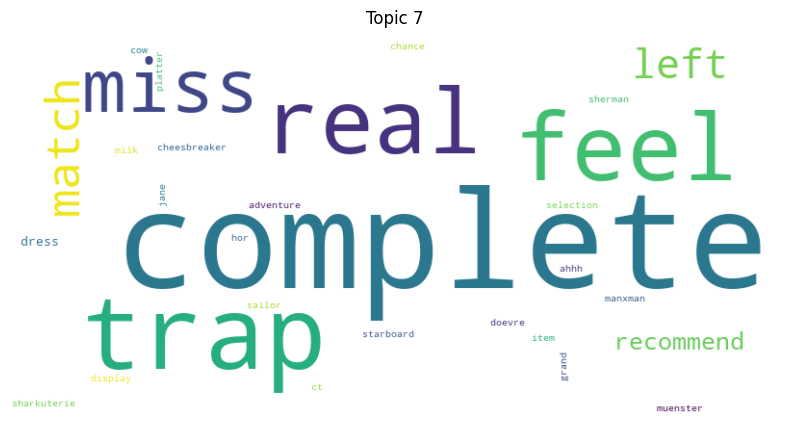

C:\Users\alexc\anaconda3\envs\caption_contest\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


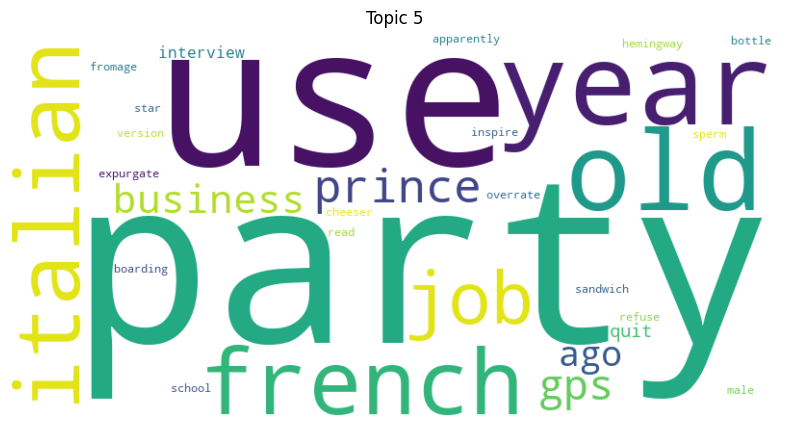

C:\Users\alexc\anaconda3\envs\caption_contest\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


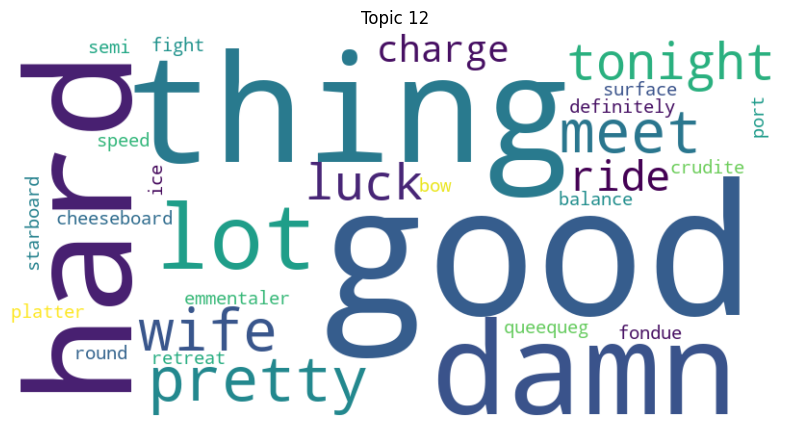

C:\Users\alexc\anaconda3\envs\caption_contest\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


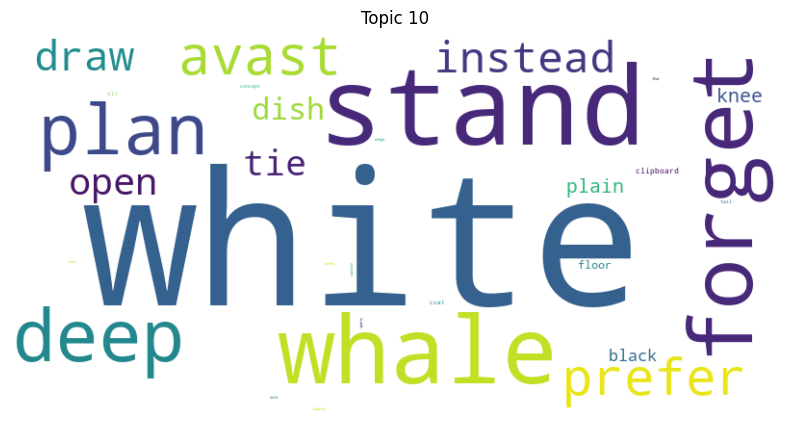

C:\Users\alexc\anaconda3\envs\caption_contest\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


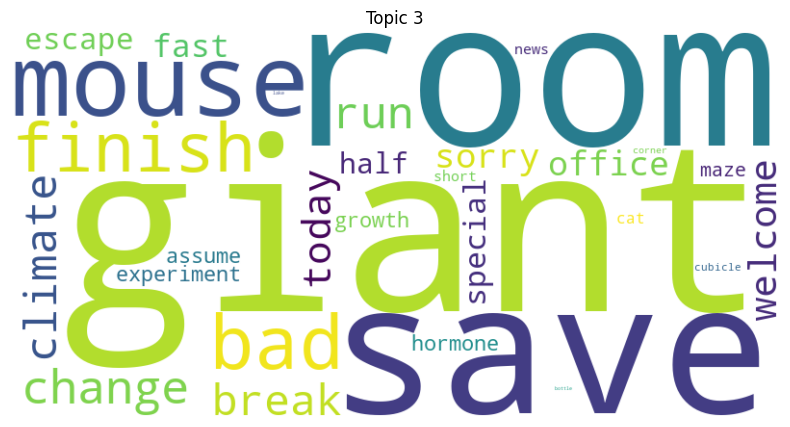

C:\Users\alexc\anaconda3\envs\caption_contest\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


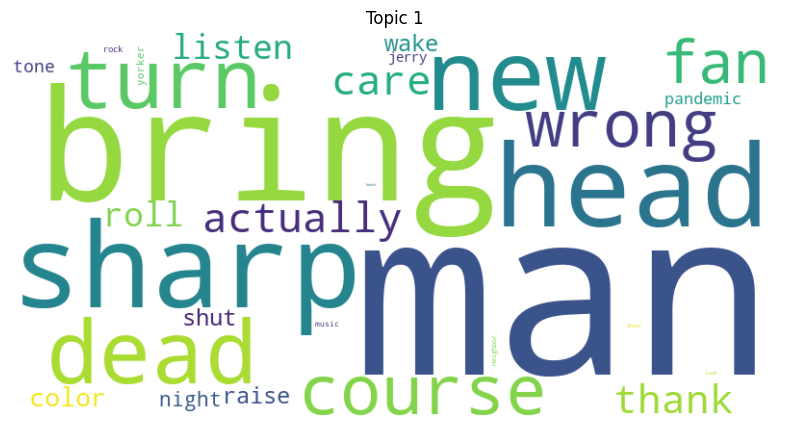

C:\Users\alexc\anaconda3\envs\caption_contest\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


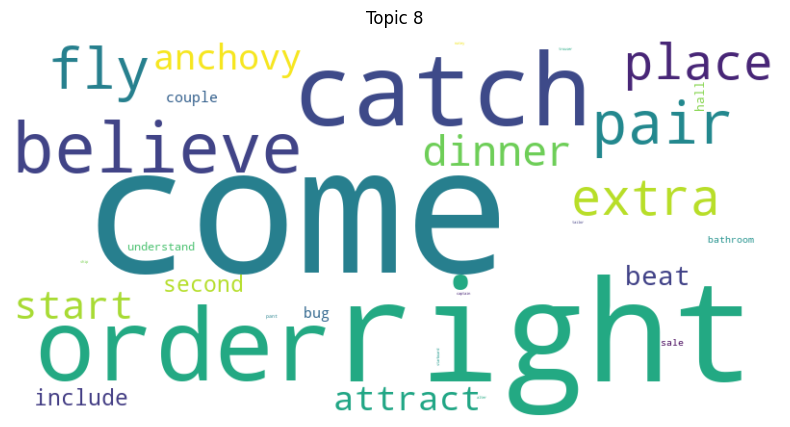

C:\Users\alexc\anaconda3\envs\caption_contest\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


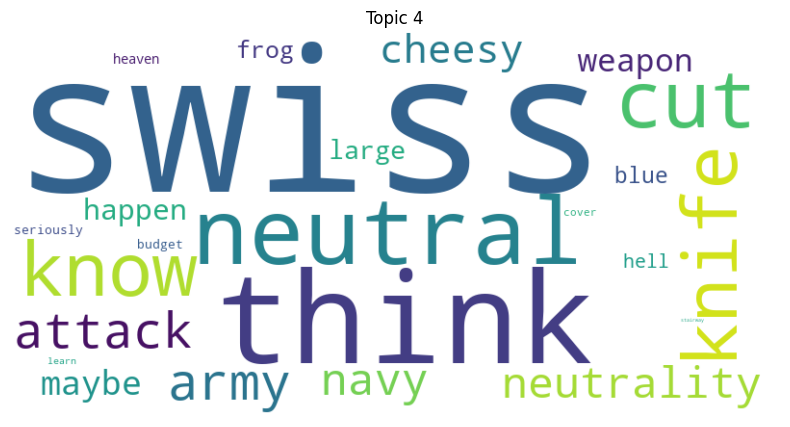

C:\Users\alexc\anaconda3\envs\caption_contest\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


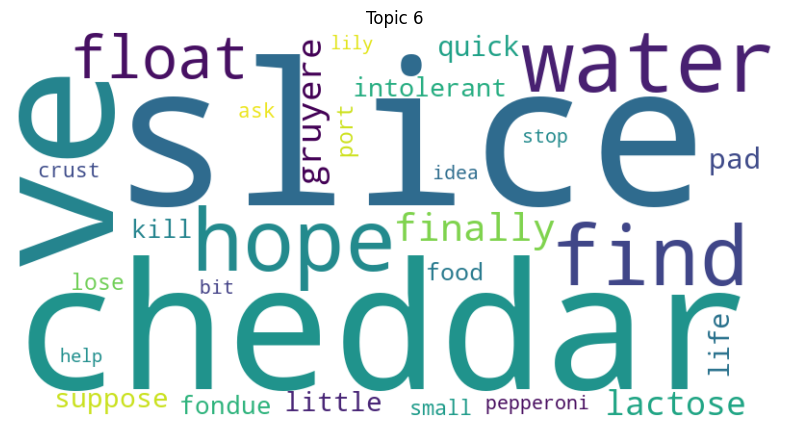

C:\Users\alexc\anaconda3\envs\caption_contest\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


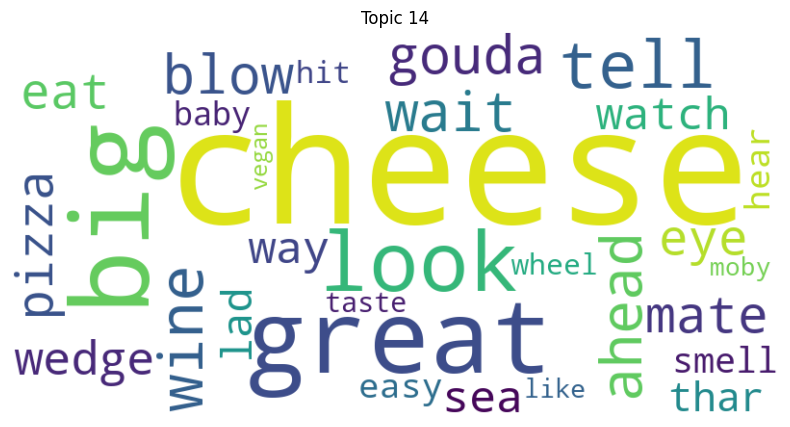

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# creating wordclouds for each topic
def create_lda_wordclouds(lda_model, num_words=30, width=800, height=400):
    topics = lda_model.show_topics(num_words=num_words, formatted=False)
    
    for topic_id, words in topics:
        wordcloud = WordCloud(width=width, height=height, background_color='white').generate_from_frequencies(dict(words))
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Topic {topic_id}")
        plt.axis('off')
        plt.show()
        
create_lda_wordclouds(lda_model, num_words=30)